<img src="./images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Qiskit Aer: Applying noise to custom gates

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

**NOTE: THIS ONLY WORKS ON QISKIT-TERRA 0.7, QISKIT-AER 0.1**

***
### Contributors
Christopher J. Wood$^{1}$

1. IBM T.J. Watson Research Center, Yorktown Heights, NY, USA

## Introduction

This notebook shows how to use some experimental noise features to define a noise model for any unitary gate, not just the ones supported by the backend.

**Disclaimer:** This is considered *experimental* as it involves modifying a compiled Qobj since the featurs are not yet supported through the Qiskit Terra `QuantumCircuit` API. As such they may change or break in future releases. Qiskit Aer includes some tools to help do this in the `qiskit_aer.utils.qobj_utils` module

In [1]:
import numpy as np

# Import Qiskit
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import amplitude_damping_error
from qiskit import compile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

# Import experimental Qobj utilities
from qiskit.qobj import QobjInstruction
from qiskit_aer.utils.qobj_utils import get_instr_pos
from qiskit_aer.utils.qobj_utils import insert_instr
from qiskit_aer.utils.qobj_utils import unitary_instr

## Simulating a custom unitary gate

The Qiskit Aer simulators support defining a custom unitary matrix QobjInstruction as

```
QobjInstruction(name='unitary', qubits=qubits, params=matrix, label=label)
```

Where `matrix` is the unitary matrix we wish to apply, `qubits` is the list of qubits the matrix acts on, and `label` is an optional label string we can later use to identify this matrix in a noise model.

For example we can make a unitary `QobjInstruction` for a Controlled-NOT gate with qubit-0 as control, and qubit-1 as target as follows:

In [2]:
cx_mat = np.array([[1, 0, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0]])
custom_cx = QobjInstruction(name='unitary', params=cx_mat,
                            qubits=[0, 1], label='custom_cx')

Or equivalently using the convenience function from `qobj_utils.unitary_instr`:

In [3]:
unitary_instr(cx_mat, [0, 1], label='custom_cx')

QobjInstruction(label='custom_cx', name='unitary', params=array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]]), qubits=[0, 1])

**Note:** The matrix is specified with respect to the tensor product $U_{b}\otimes U_{a}$ for `qubits=[a, b]`.

## Example: using the iSWAP gate to implement a CX gate

Lets consider an explicit example of using the unitary instruction for a custom gate. We will use the iSWAP gate which is an entangling two-qubit gate given by

$$\mbox{iSWAP} = \left(\begin{array} 
& 1 & 0 & 0 & 0 \\ 
0 & 0 & i & 0 \\ 
0 & i & 0 & 0 \\ 
0 & 0 & 0 & 1
\end{array}\right)$$

A CX gate can be implemented using two iSWAP gates and single qubit gates with the following circuit:

FIGURE TODO

Since we cannot insert this instruction directly using the `QuantumCircuit` API we will create the circuit with a `barrier` instruction inserted everywhere the iSWAP gate should be:

In [4]:
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
cx_circ = QuantumCircuit(qr, cr, name='cx')

# CNOT Circuit where iSWAP gates should be inserted at barrier locations
cx_circ.sdg(qr[1])
cx_circ.h(qr[1])
cx_circ.sdg(qr[0])
cx_circ.barrier(qr)  # Place iSWAP here
cx_circ.sdg(qr[0])
cx_circ.h(qr[0])
cx_circ.sdg(qr[0])
cx_circ.barrier(qr)  # Place iSWAP here
cx_circ.s(qr[1])

print("NOTE: iSWAP gates should be inserted at barrier positions")
print(cx_circ)

NOTE: iSWAP gates should be inserted at barrier positions
                     ┌─────┐ ░ ┌─────┐┌───┐┌─────┐ ░      
qr_0: |0>────────────┤ Sdg ├─░─┤ Sdg ├┤ H ├┤ Sdg ├─░──────
         ┌─────┐┌───┐└─────┘ ░ └─────┘└───┘└─────┘ ░ ┌───┐
qr_1: |0>┤ Sdg ├┤ H ├────────░─────────────────────░─┤ S ├
         └─────┘└───┘        ░                     ░ └───┘
 cr_0: 0 ═════════════════════════════════════════════════
                                                          
 cr_1: 0 ═════════════════════════════════════════════════
                                                          


Now we need to compile the circuit and insert iSWAP instructions at the barrier positions in the `QobjExperiment`. 
The `qobj_utils` includes functions to help do this (*see their docstrings for more details*):

* `get_instr_pos` will return the positions of all instructions with a given name in a given `QobjExperiment`.
* `insert_instr` will insert a `QobjInstruction` into a given `QobjExperiment` at a specific location.

Using these we can write a helper function to insert iSWAP gates after barrier operations. We will use the string label `"iswap"` for these gates so we cn assign a noise model to it later.

In [5]:
def add_iswap_after_barrier(qobj):
    """Inserts iSWAP unitary instructions after barriers."""
    iswap_mat = np.array([[1, 0, 0, 0],
                          [0, 0, 1j, 0],
                          [0, 1j, 0, 0],
                          [0, 0, 0, 1]])
    instr = unitary_instr(iswap_mat, [0, 1], 'iswap')
    for exp_pos, _ in enumerate(qobj.experiments):
        for pos in reversed(get_instr_pos(qobj, exp_pos, 'barrier')):
            insert_instr(qobj, exp_pos, instr, pos)
    return qobj

### Verifying circuit on the Aer unitary simulator

We will execute the circuit on the Aer unitary simulator to verify our qobj implements the CX gate

In [6]:
# Select UnitarySimulator backend
simulator = Aer.get_backend('unitary_simulator')

# Compile the circuit qobj and insert iSWAP instructions
qobj = compile(cx_circ, simulator,)
qobj = add_iswap_after_barrier(qobj)

# Execute on the simulator
result = simulator.run(qobj).result()
unitary = result.get_unitary(cx_circ)
print("Circuit unitary:")
print(unitary)

Circuit unitary:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


So we have confirmed that our circuit implemented the correct unitary!

## Using a custom unitary in a noise model

Now that we have executed a qobj that includes a custom unitary instruction, we can now assign a quantum error to this gate in a `NoiseModel`. To do this we simply use our unitary instruction label `iswap` for the gate name when adding a quantum error to the noise model. For our example we will create an 2-qubit error consisting of two single-qubit amplitude damping channels with different damping parameters. For now we will assume all the other circuit instructions are ideal

In [7]:
# Error parameters
param_q0 = 0.05  # damping parameter for qubit-0
param_q1 = 0.1   # damping parameter for qubit-1
p_state1 = 0.03  # |1> state equilibrium population for damping

# Construct the error
qerror_q0 = amplitude_damping_error(param_q0, excited_state_population=p_state1)
qerror_q1 = amplitude_damping_error(param_q1, excited_state_population=p_state1)
iswap_error = qerror_q1.kron(qerror_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')

Let us first take our previous CX circuit and add an initial Hadamard gate and final measurement to create a Bell-state preparation circuit that we may simulator on the `QasmSimulator` both for the ideal and noisy case

In [8]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(qr, cr, name='bell')
bell_circ.h(qr[0])
bell_circ = bell_circ + cx_circ 
bell_circ.measure(qr, cr)
print("Bell preparation circuit: iSWAPS should be inserted at barrier positions")
print(bell_circ)

Bell preparation circuit: iSWAPS should be inserted at barrier positions
                     ┌───┐┌─────┐ ░ ┌─────┐┌───┐┌─────┐ ░ ┌─┐        
qr_0: |0>────────────┤ H ├┤ Sdg ├─░─┤ Sdg ├┤ H ├┤ Sdg ├─░─┤M├────────
         ┌─────┐┌───┐└───┘└─────┘ ░ └─────┘└───┘└─────┘ ░ └╥┘┌───┐┌─┐
qr_1: |0>┤ Sdg ├┤ H ├─────────────░─────────────────────░──╫─┤ S ├┤M├
         └─────┘└───┘             ░                     ░  ║ └───┘└╥┘
 cr_0: 0 ══════════════════════════════════════════════════╩═══════╬═
                                                                   ║ 
 cr_1: 0 ══════════════════════════════════════════════════════════╩═
                                                                     


Again we must add iSWAP gates back into the compiled qobj for execution on the Aer Qasm simulator

In [9]:
# Select UnitarySimulator backend
simulator = Aer.get_backend('qasm_simulator')

# Compile the circuit qobj and insert iSWAP instructions
qobj = compile(bell_circ, simulator,)
qobj = add_iswap_after_barrier(qobj)

### Ideal output

Lets first see the ideal output. Since this generates a Bell-state we expect two peaks for 00 and 11

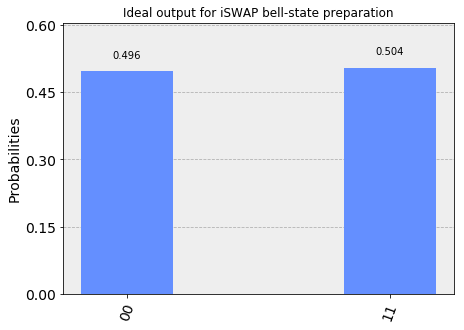

In [10]:
# Execute on the simulator without noise
result = simulator.run(qobj).result()
ideal_counts = result.get_counts(bell_circ)
plot_histogram(ideal_counts, title='Ideal output for iSWAP bell-state preparation')

### Noisy circuit execution

Finally lets now simulate it with our custom noise model. Since there is a small amplitude damping error on the two qubit gates we expect small additional peaks for the 01 and 10 outcome probabilities

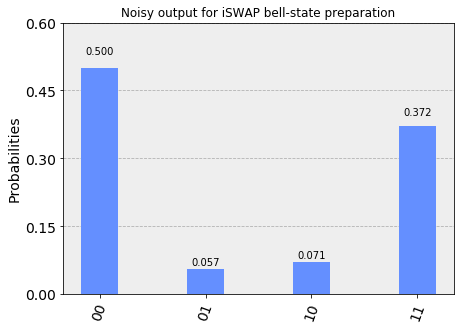

In [11]:
# Execute on the simulator without noise
result = simulator.run(qobj, noise_model=noise_model).result()
noise_counts = result.get_counts(bell_circ)
plot_histogram(noise_counts, title='Noisy output for iSWAP bell-state preparation')